In [1]:
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['font.size'] = 15
import matplotlib.gridspec as gridspec

import networkx as nx

import HTC_utils as HTC

from tqdm.auto import tqdm

import imageio
import os

In [2]:
W = np.loadtxt('connectome.txt')
Wnorm = HTC.normalize(W)
N = W.shape[0]
Gconn = nx.from_numpy_array(W)

Wer = np.load('ER_with_weights.npy')
Wer_norm = HTC.normalize(Wer)
Ger = nx.from_numpy_array(Wer)

coo = np.loadtxt('group_mean_region_xyz_centers_file.txt')

In [3]:
r1 = 1e-3
r2 = 3e-1

Tminus = r1 * r2 / (r1 + r2 + r1*r2)
Tplus = r2 / (2*r2 +1)

xplus = Tplus
yplus = Tplus / r2

xminus = Tminus
yminus = Tminus / r2

In [4]:
Ts = [0.05, 0.10, 0.12, 0.13, 0.132, 0.135, 0.14, 0.15]

traj_er = []
states_er = []
traj_conn = []
states_conn = []

for T in Ts:
    act, refr, states = HTC.simulate_trajectory(Wer_norm, xplus, yplus, T, r1, r2, steps=int(1e3), eq_steps=int(1e4))
    traj_er.append([act, refr])
    states_er.append(states)
    
    act, refr, states = HTC.simulate_trajectory(Wnorm, xplus, yplus, T, r1, r2, steps=int(1e3), eq_steps=int(1e4))
    traj_conn.append([act, refr])
    states_conn.append(states)

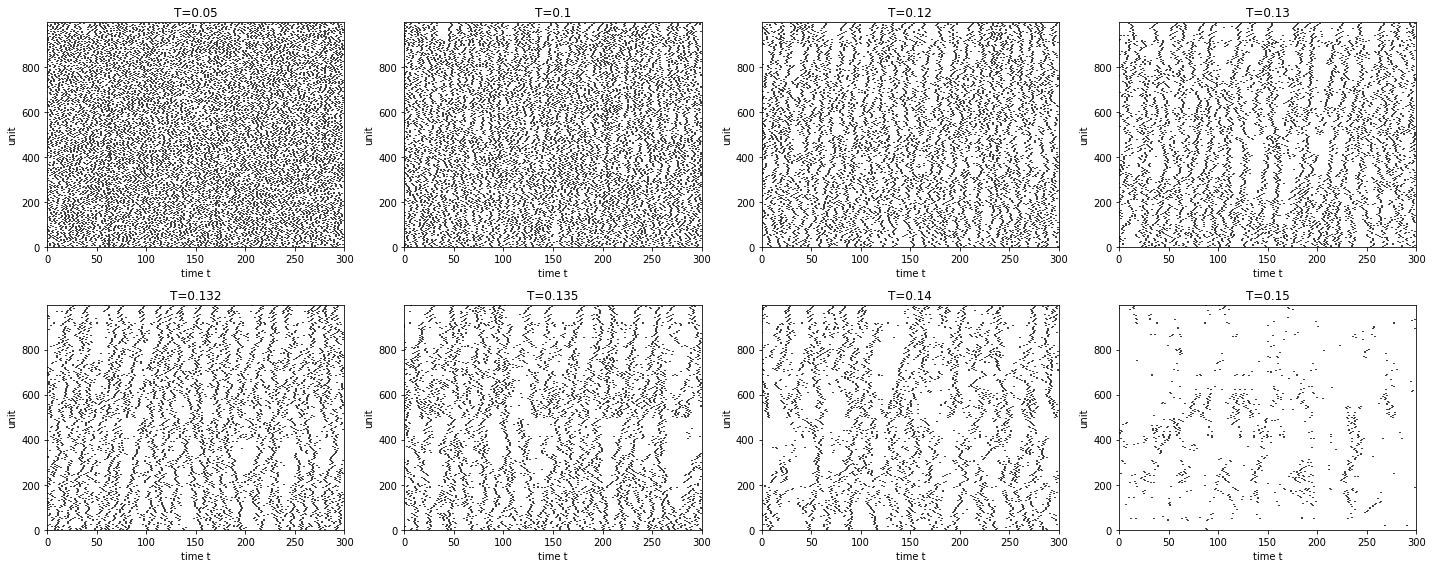

In [5]:
t0 = 200
dt = 300

plt.figure(figsize=(20,8))

for i, T in enumerate(Ts):
    ax = plt.subplot(2,len(Ts)//2,i+1)
    
    pos = [np.where(tmp[t0:t0+dt]==1)[0] for tmp in states_conn[i].T]
    
    plt.eventplot(pos, linelengths=1, colors='k')

    plt.xlabel('time t')
    plt.ylabel('unit')
    plt.title(f'T={T}')
    
    plt.xlim([0,dt])
    plt.ylim([0,len(pos)])
    
    #ax.set_facecolor('pink')
    
plt.tight_layout()
plt.show()

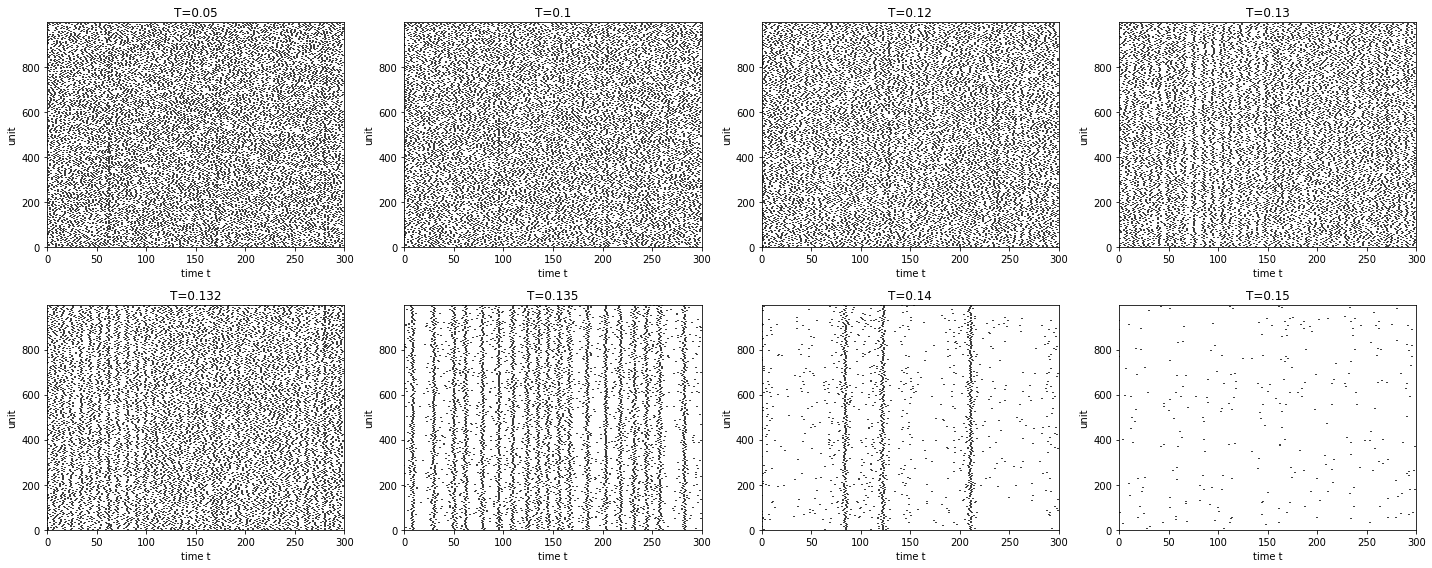

In [6]:
t0 = 200
dt = 300

plt.figure(figsize=(20,8))

for i, T in enumerate(Ts):
    plt.subplot(2,len(Ts)//2,i+1)
    
    pos = [np.where(tmp[t0:t0+dt]==1)[0] for tmp in states_er[i].T]
    
    plt.eventplot(pos, linelengths=1, colors='k')

    plt.xlabel('time t')
    plt.ylabel('unit')
    plt.title(f'T={T}')
    
    plt.xlim([0,dt])
    plt.ylim([0,len(pos)])
    
plt.tight_layout()
plt.show()

In [10]:
def drawConnectome(G, states, name, t0=200, dt=200):
    fig = plt.figure(figsize=(14,8))
    gs = gridspec.GridSpec(nrows=2, ncols=10, height_ratios=[1, 0.6])

    ax1 = fig.add_subplot(gs[0, :5])
    ax2 = fig.add_subplot(gs[0, 5:])
    ax4 = fig.add_subplot(gs[1, 2:8])

    ### Raster plot
    pos = [np.where(tmp[t0:t0+dt]==1)[0] for tmp in states.T]

    ax4.eventplot(pos, linelengths=1, colors='k')

    ax4.set_xlabel('time t', size=15)
    ax4.set_ylabel('unit', size=15)
    #plt.title(f'T={T}')
    
    line = ax4.axvline(-1, c='red')

    ax4.set_xlim([0,dt])
    ax4.set_ylim([0,len(pos)])
    
    ### Plot networks
    for t in tqdm(range(dt)):
        ax1.clear()
        ax2.clear()
        line.remove()
        
        line = ax4.axvline(t, c='red')
        state = (states[t0+t]>0).astype(int)
        state_colors = ['red' if x==1 else 'gainsboro' for x in state]
        nx.draw(G, pos=coo[:,[0,1]], node_size=30, width=0.01, ax=ax1, node_color=state_colors)
        nx.draw(G, pos=coo[:,[1,2]], node_size=30, width=0.01, ax=ax2, node_color=state_colors)
    
        fname = 'videos/'+name+f'_t_{t}.png'
        plt.tight_layout()
        plt.savefig(fname)
    plt.close()
    #plt.show()

In [11]:
def drawNetw(G, states, name, t0=200, dt=200):
    fig, (ax1, ax4) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={'height_ratios': [1, 0.6]})
    
    #ax1 = plt.subplot(1,2,1)
    #ax4 = plt.subplot(1,2,2)

    ### Raster plot
    pos = [np.where(tmp[t0:t0+dt]==1)[0] for tmp in states.T]

    ax4.eventplot(pos, linelengths=1, colors='k')

    ax4.set_xlabel('time t', size=15)
    ax4.set_ylabel('unit', size=15)    
    line = ax4.axvline(-1, c='red')
    ax4.set_xlim([0,dt])
    ax4.set_ylim([0,len(pos)])
    
    ### Store position
    pos = nx.spring_layout(G)
    
    ### Plot networks
    for t in tqdm(range(dt)):
        ax1.clear()
        line.remove()
        
        line = ax4.axvline(t, c='red')
        state = (states[t0+t]>0).astype(int)
        state_colors = ['red' if x==1 else 'gainsboro' for x in state]
        nx.draw(G, pos=pos, node_size=30, width=0.01, ax=ax1, node_color=state_colors)
    
        fname = 'videos/'+name+f'_t_{t}.png'
        plt.tight_layout()
        plt.savefig(fname)
    plt.close()
    #plt.show()

In [12]:
tmax = 200

#for ii in [0,2,5,7]:
for ii in [6]:

    T = Ts[ii]
    name = f'conn_T_{T}'
    print(f'[*] T={T}')
    
    drawConnectome(Gconn, states_conn[ii], name=name, dt=tmax)

    ### Create .gif
    images = []
    for t in range(tmax):
        fname = 'videos/'+name+f'_t_{t}.png'
        images.append(imageio.imread(fname))
        os.remove(fname)
    imageio.mimsave('videos/'+name+'.gif', images)

[*] T=0.14


  0%|          | 0/200 [00:00<?, ?it/s]

In [88]:
tmax = 200

for ii in [0,2,4,5,6]:
    
    T = Ts[ii]
    name = f'er_T_{T}'
    print(f'[*] T={T}')
    
    drawNetw(Ger, states_er[ii], name=name, dt=tmax)

    ### Create .gif
    images = []
    for t in range(tmax):
        fname = 'videos/'+name+f'_t_{t}.png'
        images.append(imageio.imread(fname))
        os.remove(fname)
    imageio.mimsave('videos/'+name+'.gif', images)

[*] T=0.05


  0%|          | 0/200 [00:00<?, ?it/s]

[*] T=0.12


  0%|          | 0/200 [00:00<?, ?it/s]

[*] T=0.132


  0%|          | 0/200 [00:00<?, ?it/s]

[*] T=0.135


  0%|          | 0/200 [00:00<?, ?it/s]

[*] T=0.14


  0%|          | 0/200 [00:00<?, ?it/s]

In [86]:
tmax = 2

ii = 7
T = Ts[ii]

for ii, T in enumerate(Ts[:1]):
    name = f'conn_T_{T}'
    print(f'[*] T={T}')
    
    drawNetw(Ger, states_er[ii], name=name, dt=tmax)

    ### Create .gif
    images = []
    for t in range(tmax):
        fname = 'videos/'+name+f'_t_{t}.png'
        images.append(imageio.imread(fname))
        os.remove(fname)
    imageio.mimsave('videos/'+name+'aaa.gif', images)

[*] T=0.05


  0%|          | 0/2 [00:00<?, ?it/s]